# SCIKIT-TIME (SKTIME) WORKSHOP

## Imports

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px'> 
    <b>Scikit-Time</b> (sktime) is an open-source Python toolbox for machine learning with time series. It is a community-driven project funded by the UK Economic and Social Research Council, the Consumer Data Research Centre, and The Alan Turing Institute.

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px'> 
<u><b>Sktime</b> extends and the scikit-learn API to time series tasks</u>. It provides the necessary algorithms and transformation tools to efficiently solve for time series regression, forecasting, and classification tasks. The library includes dedicated time series learning algorithms and transformation methods not readily available in other common libraries.

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    Let's install sktime and its dependencies

In [21]:
!pip install sktime --user
!pip install pmdarima
!pip install tbats

distutils: C:\Users\Администратор\AppData\Roaming\Python\Python37\Include\UNKNOWN
sysconfig: C:\Users\Администратор\AppData\Roaming\Python\Python37\Include
user = True
home = None
root = None
prefix = None


distutils: c:\programdata\anaconda3\Include\UNKNOWN
sysconfig: c:\programdata\anaconda3\Include
user = False
home = None
root = None
prefix = None
distutils: c:\programdata\anaconda3\Include\UNKNOWN
sysconfig: c:\programdata\anaconda3\Include
user = False
home = None
root = None
prefix = None


In [1]:
import sktime
import pandas as pd
import numpy as np
from warnings import simplefilter

In [2]:

from sktime.datasets import load_airline

from sktime.forecasting.model_selection import temporal_train_test_split



from sktime.forecasting.base import ForecastingHorizon

from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)


from sktime.forecasting.model_evaluation import evaluate

from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)

from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sktime.forecasting.naive import NaiveForecaster

from sktime.forecasting.theta import ThetaForecaster

from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.performance_metrics.forecasting import sMAPE, smape_loss

from sktime.transformations.series.detrend import Deseasonalizer, Detrender

from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)

%matplotlib inline

## Datasets

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 

For using built-in datasets we can import it form the corresponding module `datasets` where
up-to-date you can find [here](https://www.sktime.org/en/latest/api_reference.html?highlight=datasets#sktime-datasets-datasets)
<br> For the first let's import already familiar to you dataset with airline passengers 

output data type:  <class 'pandas.core.series.Series'>
count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: Number of airline passengers, dtype: float64


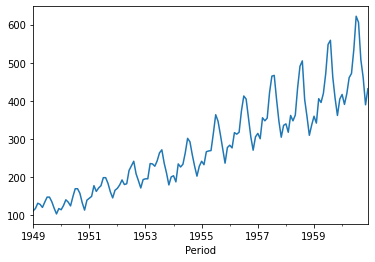

In [3]:
y = sktime.datasets.load_airline()

print('output data type: ',type(y))

y.plot();


print(y.describe())

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 

We can also use built-in method `plot_series` for data visualization

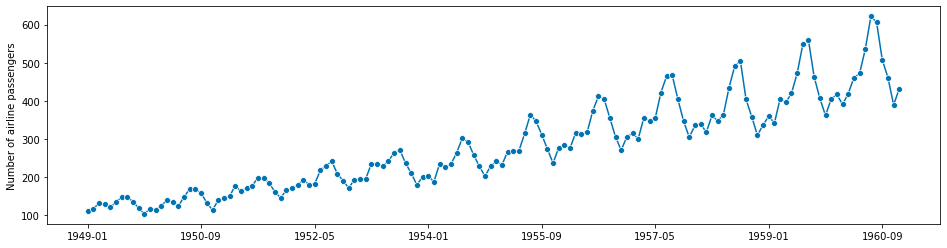

In [4]:
sktime.utils.plotting.plot_series(y);


<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    For split arrays or matrices into sequential train and test subsets we will use `'temporal_train_test_split'` method.<br>
    We will use forecasting with predefined horizon, using variable `TEST_SIZE`.

check splitted data size:  108 36


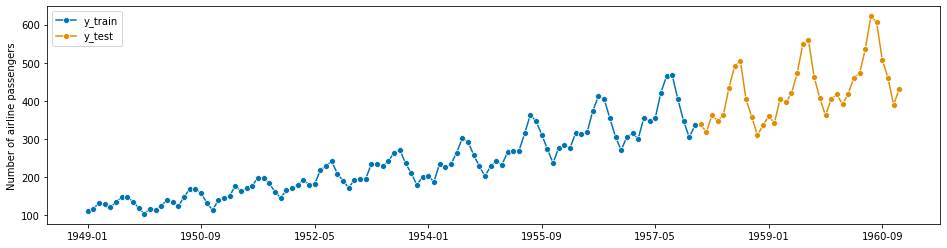

In [5]:
TEST_SIZE = 36

y_train, y_test = sktime.forecasting.model_selection.temporal_train_test_split(y, test_size=TEST_SIZE)

print('check splitted data size: ', y_train.shape[0], y_test.shape[0])

sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train", "y_test"]);



<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
After splitting we can specify the forecasting horizon using the absolute time points we want to predict. 

In [6]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
print(fh)

ForecastingHorizon(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', freq='M', is_relative=False)


<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
Alternatively we can use relative points using `np.array`

In [7]:
fh = np.arange(len(y_test)) + 1

In [8]:
fh = np.array([2, 5])  # 2nd and 5th step ahead

## Forecast task

### Conventional Forecast

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    Let's make naive forecast like we did in the previous workshop.<br>
    The SKTime allow to make it in common scikit-based style.<br>
<br>
    For score estimation here will be use so-called Symmetry MAPE measure:
    $$ sMAPE =\frac{1}{H}\sum_{i=1}^{H} \frac{|y(h_i) − \hat{y}(h_i)|}{|y(h_i)| + |\hat{y}(h_i)|}
 $$
    
    
For `Naive` case:

score =  0.2319577038795143


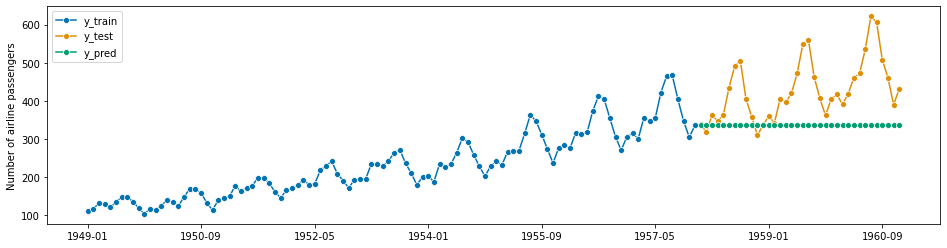

In [9]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last")

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print('score = ',smape_loss(y_pred, y_test))

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 

For `Seasonal Naive` case:

score =  0.145427686270316


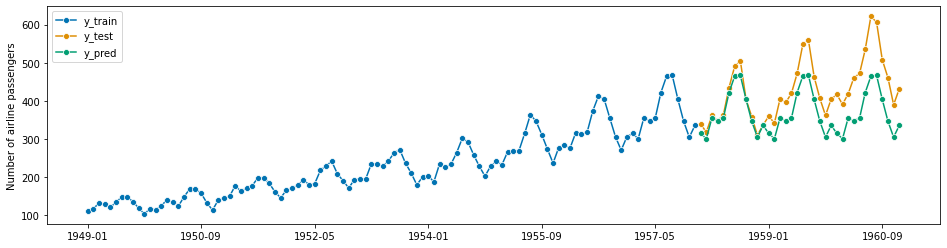

In [10]:
forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print('score = ',smape_loss(y_pred, y_test))

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 

For `Exponential Smoothing`(Holt-Winter) case:

score =  0.05027652903776341


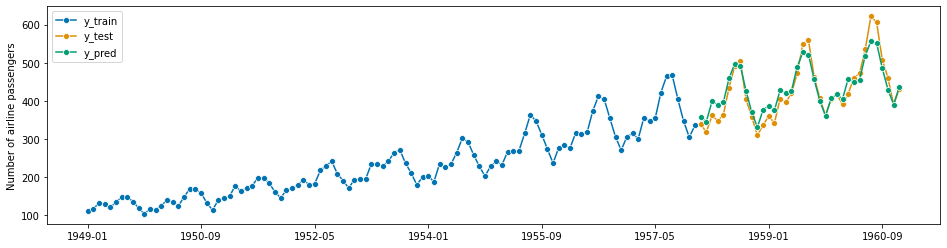

In [11]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print('score = ',smape_loss(y_pred, y_test))

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    
 Note for obtaining Simple Exponential Smoothing (SES) and Double  Exponential Smoothing (HOLT, DEA) use
```python
ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)
```

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    

For Ensemble of methods use

score =  0.1393047282084183


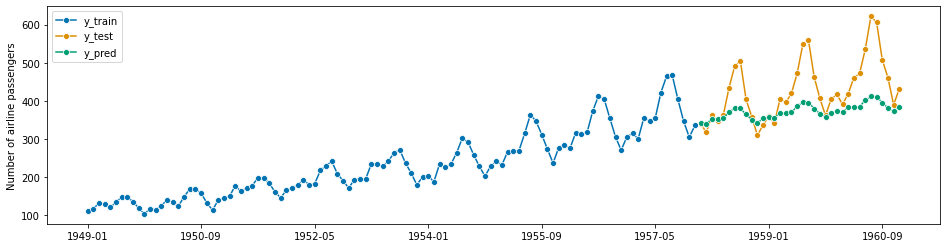

In [12]:
ses = ExponentialSmoothing(sp=12)

holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)

damped_holt = ExponentialSmoothing(trend="add", damped_trend=True, sp=12)

holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)

forecaster = EnsembleForecaster(
    [
        ("ses", ses),
        ("holt", holt),
        ("damped", damped_holt),
        ("holt-winter",holt_winter)
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print('score = ',smape_loss(y_pred, y_test))

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 

For Automated hyperparameter optimized `Exponential Smoothing`(Holt-Winter) case:

score =  0.06318722677034444


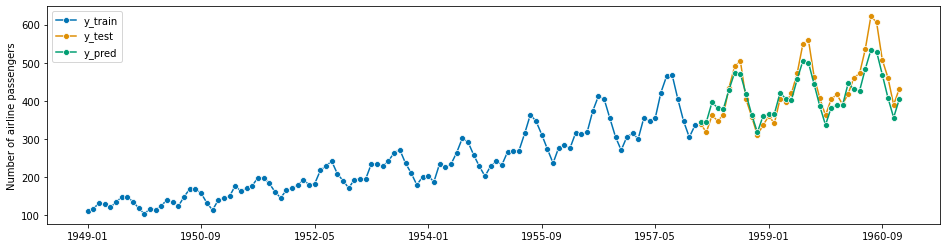

In [13]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print('score = ',smape_loss(y_pred, y_test))

### Exercise 1

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 

1. Compare the accuracy of all the possible ETS cases of 
`ExponentialSmoothing` 
such as 
```python
trend : str{"add", "mul", "additive", "multiplicative", None}, optional
(default=None)
    Type of trend component.
damped_trend : bool, optional (default=None)
    Should the trend component be damped.
seasonal : {"add", "mul", "additive", "multiplicative", None}, optional
(default=None)
    Type of seasonal component.
```




<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    <blockquote>
        <em>Note</em>:<ul> In the generalized form the smoothing techniques can be joint in the so-called <b>Error-Trend_Seasonality (ETS)</b> model. <br>
The model can be described as <b>ETS(Error,Trend,Seasonal)s = ETS(X,X,X)s</b>, where <b>X can be N-None, A-additive, M-multiplicative, Ad-additive dumped, s-sesonal period if S is not None</b>. <br>
With this notations:<ul>
<li> Simple Exponential smoothing corresponds to the ETS(A,N,N).  
<li> Triple Exponential smoothing corresponds to the ETS(A,A,A). <br>
    
For Additive/Multiplicative Error model depends on the empty or presence of the trend and seasonality the following cases are possible

> 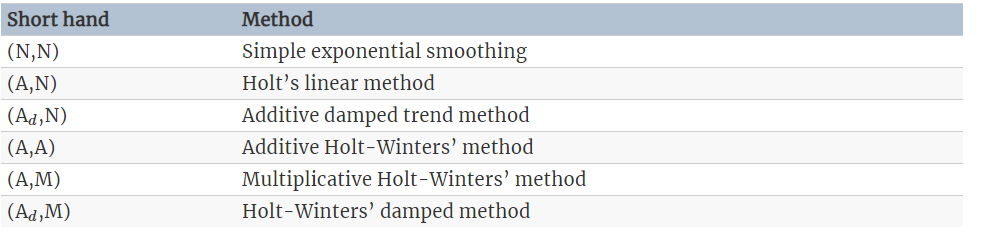

> 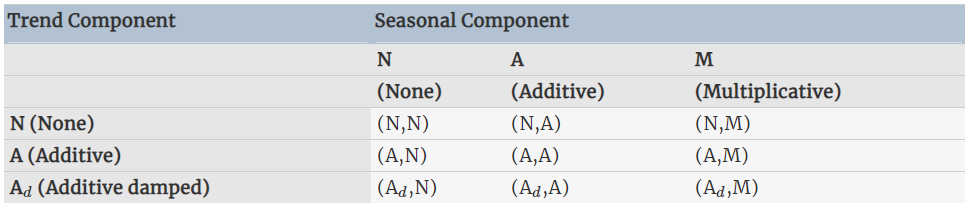

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 

2. Make comparison for the cases of
```python
error : str, optional
    The error model. "add" (default) or "mul".
trend : str or None, optional
    The trend component model. "add", "mul", or None (default).
damped_trend : bool, optional
    Whether or not an included trend component is damped. Default is
    False.
seasonal : str, optional
    The seasonality model. "add", "mul", or None (default).
    ```

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>  

3. Compare the results of Holt-Winter Forecast using (or without) time series transform parameter
```python
use_boxcox : {True, False, 'log', float}, optional
    Should the Box-Cox transform be applied to the data first? If 'log'
    then apply the log. If float then use lambda equal to float.
```

### Scikit-learn wrapped forecasts

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
Beside the built-in methods `SKTime` allow one to apply `scikit-learn` based approaches.<br>
    For instance, forecasting task can be compared to the regression task in `sklearn`.
    However direct using of conventional `sklearn` regression requiring presence of data and labels, which are do not necessary in time series.<br>
    Actually direct using of `sklearn` can also lead to several problems.<br>
    <br>


<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
The better way to make forecast using conventional regression - is to use so-called <b>Forecast Reduction</b> technique, which is transformation of the implicitly accompanying long-horizon regression problem to the sliding window based problem.<br>
    This can be performed by method `make_reduction` as it is shown below.

The idea of Reduction is to reduce the regression through the time series problem to the tabular regression problem like it is shown below.<br>
<em>Please Note that in the tabular or rolling window regression problem, during the training stage you may use the predicted values instead of known in the corresponding positions. Like it is shown by gray arrows.   </em>
   
  
    
    
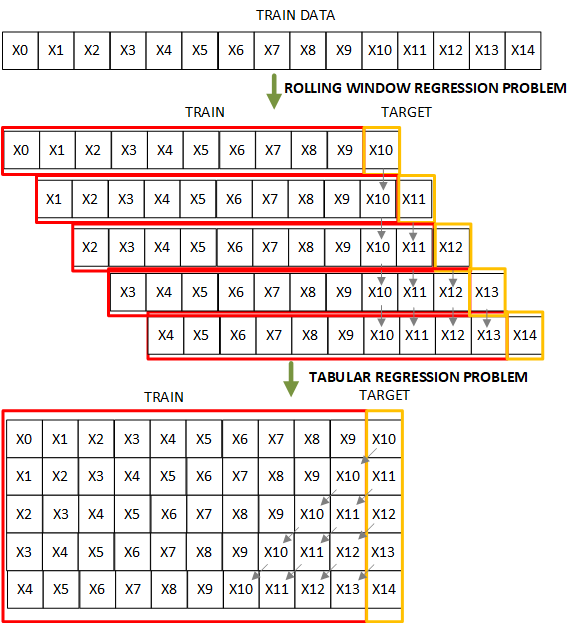

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    Let's see how method `make_reduction` work.  There are "direct", "recursive" and  "multioutput" strategies of forecasting.<br> <li>In the direct strategy we use different forecasts for each output (target) (without gray arrows).
    <li>In the recursive strategy we use previous results in the forecasts for each next output (with gray arrows).
    <li>In the multioutput strategy we directly predict several steps.    


score =  0.2329490896108744


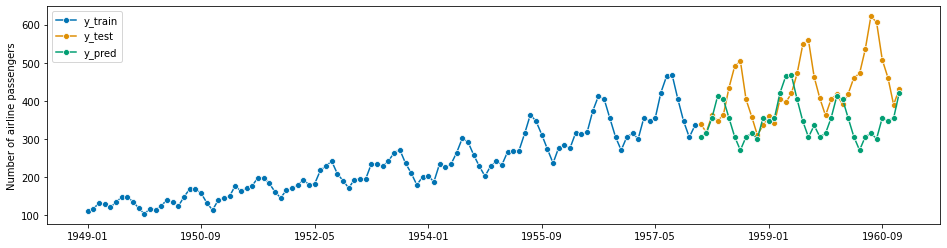

In [14]:
from sklearn.neighbors import KNeighborsRegressor

REGRESSION_WINDOW = 5

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=REGRESSION_WINDOW, strategy="recursive")



forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print('score = ',smape_loss(y_pred, y_test))

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    In `make_reduction`, both the `window_length` and `strategy` arguments are hyper-parameters which we may want to optimise.
    <br> In the example below we use grid search for checking the best window length.<br>
    For this case we:<ul>
    <li> create grid of search `grid`.        
    <li> create initial forecaster, with regressor KNeighborsRegressor.
    <li> Split corss-validation part (we did it by sliding window start for 80% of sample size and moving with length 25 points up to the end),
    <li> Make forecasting grid search with refitting on each iteration and SMAPE function as score.

In [15]:
grid = {"window_length": [5, 7, 10, 12, 15,17,20]}



#initial forecaster
regressor  = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, 
                            window_length=grid["window_length"][-1], 
                            strategy="recursive")

# use temporal cross-validation to find the optimal parameter.
cros_val = SlidingWindowSplitter( initial_window=int(len(y_train) * 0.7), window_length=25)

#grid search
gscv = ForecastingGridSearchCV(forecaster, strategy="refit", cv=cros_val, param_grid=grid, scoring=sMAPE())

gscv.fit(y_train)


print('best window size = ',gscv.best_params_)

best window size =  {'window_length': 12}


<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    to see the full protocol use the following code

In [16]:
pd.DataFrame(gscv.cv_results_)

,mean_test_sMAPE,mean_fit_time,mean_pred_time,params,rank_test_sMAPE
0,0.133554,0.001182,0.002694,{'window_length': 5},7.0
1,0.117308,0.001151,0.002576,{'window_length': 7},6.0
2,0.095433,0.001213,0.002512,{'window_length': 10},2.0
3,0.090602,0.001333,0.002454,{'window_length': 12},1.0
4,0.095508,0.001121,0.002542,{'window_length': 15},4.0
5,0.095508,0.001181,0.002361,{'window_length': 17},4.0
6,0.095508,0.001150,0.002240,{'window_length': 20},4.0


<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    after search you can make prediction with the best results

score =  0.14008272913734346


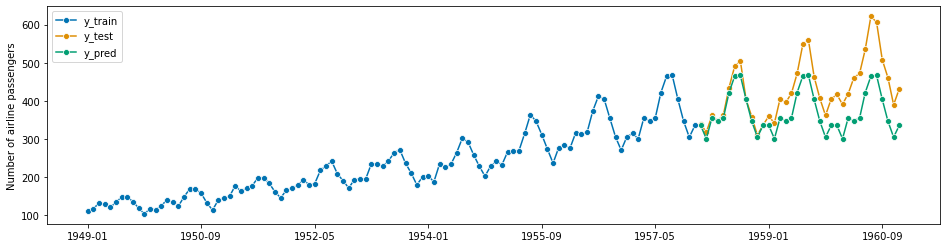

In [17]:
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print('score = ',smape_loss(y_pred, y_test))

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>
    
It is also can be made grid search through the methods.

In [18]:
ses = ExponentialSmoothing(sp=12)

holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)

holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)


forecaster = MultiplexForecaster(
    forecasters=[
        ("ses", ses),
        ("holt", holt),
        ("holt_winter", holt_winter),
    ]
)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), window_length=30)

forecaster_grid = {"selected_forecaster": ["ses", "holt", "holt_winter"]}

gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_grid)

gscv.fit(y_train)

print(gscv.best_params_, "\n\n\n", gscv.best_forecaster_)

{'selected_forecaster': 'holt_winter'} 


 MultiplexForecaster(forecasters=[('ses', ExponentialSmoothing(sp=12)),
                                 ('holt',
                                  ExponentialSmoothing(sp=12, trend='add')),
                                 ('holt_winter',
                                  ExponentialSmoothing(seasonal='additive',
                                                       sp=12, trend='add'))],
                    selected_forecaster='holt_winter')


0.05027652903776341

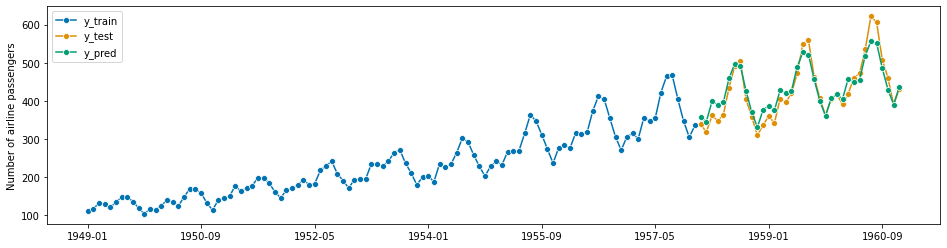

In [19]:
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print('score = ',smape_loss(y_pred, y_test))

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>

Beyond a simple train-test-split if we want to backtest multiple fit/updates on different data it can be done using `ExpandingWindowSplitter`.

In [61]:
from sklearn.ensemble import RandomForestRegressor

regressor  = RandomForestRegressor()

forecaster = make_reduction(regressor, 
                            window_length=12, 
                            strategy="recursive")

cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)
df.iloc[:, :5]

,cutoff,fit_time,len_train_window,pred_time,test_sMAPE
0,1954-12,0.125927,72,0.071958,0.132538
1,1955-12,0.123929,84,0.074957,0.055439
2,1956-12,0.126938,96,0.078944,0.078507
3,1957-12,0.142903,108,0.084950,0.127128
4,1958-12,0.146924,120,0.083951,0.070665
5,1959-12,0.140903,132,0.072958,0.053559


<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>

you may see the visualization of `ExpandingWindowSplitter` backtest below.

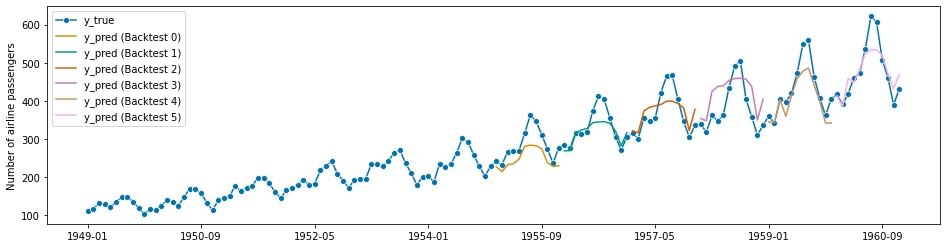

In [60]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o", "", "", "", "", "", ""],
    labels=["y_true"] + ["y_pred (Backtest " + str(x) + ")" for x in range(6)],
)
ax.legend();

### Exercise 2

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
<ol>    
<li> Make <code>EnsembleForecaster</code> with at lest two methods from both <code>sktime</code> and <code>sklearn</code>.
<li> Make <code>ForecastingGridSearchCV</code> for number of nearest neighbors.
<li> Make <code>MultiplexForecaster</code> for Naive, Holt-Winter, Random Forest Regressor, AdaBoostRegressor.    

Pleas note that `sktime` contain a lot of adopted borrowings form other packages. Several examples are shown below 

0.04117062367046532

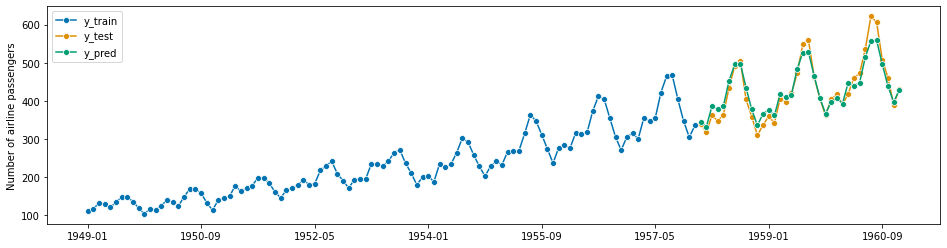

In [20]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print('score = ',smape_loss(y_pred, y_test))


0.08493353477049963

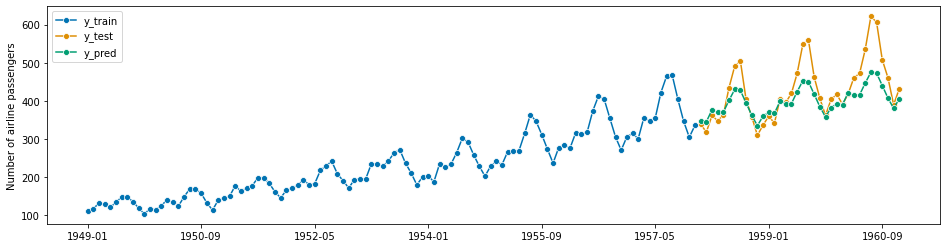

In [21]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print('score = ',smape_loss(y_pred, y_test))

## Data Transformation

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
    Sktimes contains a number of tools for time series decomposition and components forecasting.
    One of the generic tool is `detrending transformation`.<br>
    We can use it with trend forecast method `PolynomialTrendForecaster`. In the example below we will use linear trend (degree of polynom is 1).

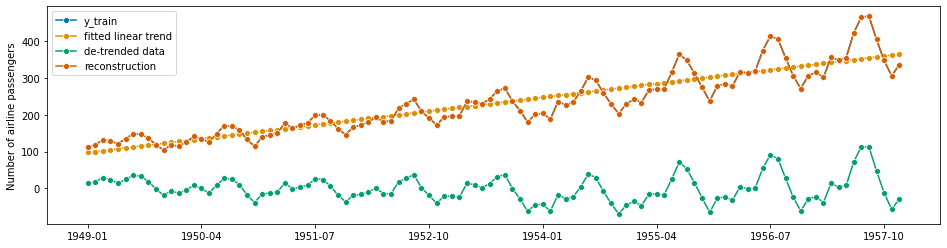

In [27]:
# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)

transformer = Detrender(forecaster=forecaster)

y_detrend = transformer.fit_transform(y_train)

fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon

y_trend = forecaster.fit(y_train).predict(fh=fh_ins)

reconstructed = y_trend + y_detrend

plot_series(y_train, y_trend, y_detrend, reconstructed,
            labels=["y_train", "fitted linear trend", "de-trended data", "reconstruction"]);

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'> 
  We can make the pipeline of transformation for forecast as it is shown below

score =  0.03983950097748029


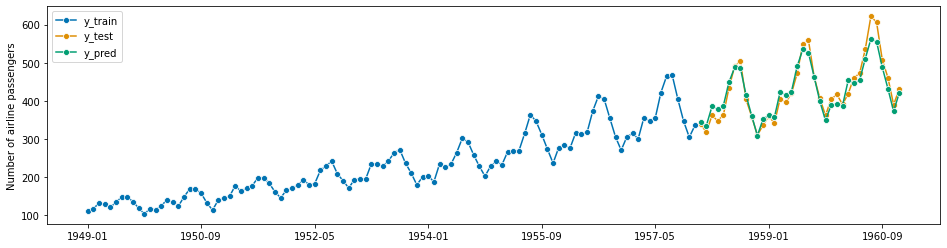

In [32]:
regressor  = KNeighborsRegressor(n_neighbors=3)

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ( "forecast", make_reduction(regressor,window_length=15,strategy="recursive",),
         ),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print('score = ',smape_loss(y_pred, y_test))

### Exercise 3

<font size=4.5pt  face = 'georgia' style='Line-height :3'><p style='text-align: justify; padding:35px; margin-top:-35px; margin-bottom:-35px'>    <ol> 
<li> Make pipeline with Deseasonalizer and Naive Forecast on the residual part, compare and explain the difference with the case without transformation
<li> Make trend, seasonal part and residual decomposition. show the results.
